<a href="https://colab.research.google.com/github/WooHyunJ/DATATHON_9/blob/main/%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%86%A4_%EB%AA%A8%EB%8D%B8_%EA%B5%AC%EC%B6%95_%26_SHAP_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.7 MB/s eta 0:00:00


In [ ]:
!pip install imbalanced-learn

In [ ]:
#한글 글씨 폰트 설치
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/데이터톤/final_csv11.csv")

In [ ]:
df['냉동식품섭취횟수'] = df['냉동식품섭취횟수'].round(0).astype(int)

In [ ]:
# 허리둘레 기준 (남≥90cm, 여≥85cm 예시)
df['허리둘레_기준'] = (
    ((df['성별']==1) & (df['허리둘레'] >= 90)) |
    ((df['성별']==2) & (df['허리둘레'] >= 85))
).astype(int)

# 중성지방 ≥150 mg/dL
df['중성지방_기준'] = (df['중성지방'] >= 150).astype(int)

# HDL (남<40, 여<50)
df['HDL_기준'] = (
    ((df['성별']==1) & (df['HDL콜레스테롤'] < 40)) |
    ((df['성별']==2) & (df['HDL콜레스테롤'] < 50))
).astype(int)

# 수축기혈압 ≥130 또는 이완기혈압 ≥85
df['혈압_기준'] = (
    (df['수축기혈압'] >= 130) |
    (df['이완기혈압'] >= 85)
).astype(int)

# 공복혈당 ≥100 mg/dL
df['혈당_기준'] = (df['공복혈당'] >= 100).astype(int)


In [ ]:
df_40_70 = df[(df['나이'] >= 40) & (df['나이'] <= 70)].copy()

# 기준 5개 합산
criteria_cols = ['허리둘레_기준','중성지방_기준','HDL_기준','혈압_기준','혈당_기준']
df_40_70['기준_충족수'] = df_40_70[criteria_cols].sum(axis=1)

# 대사증후군 위험군(1) vs 대조군(0)
df_40_70['대사증후군_위험군'] = (df_40_70['기준_충족수'] >= 3).astype(int)


In [ ]:
# 기준 5개 합산
criteria_cols = ['허리둘레_기준','중성지방_기준','HDL_기준','혈압_기준','혈당_기준']
df['기준_충족수'] = df[criteria_cols].sum(axis=1)

# 대사증후군 위험군(1) vs 대조군(0)
df['대사증후군_위험군'] = (df['기준_충족수'] >= 3).astype(int)


In [ ]:
df = df.rename(columns={'하루평균수면시간': '수면장애여부'})
df = df.rename(columns={'주당운동빈도': '운동여부'})

In [ ]:
df = df[df['운동여부'].isin([1, 2])]
df = df[df['수면장애여부'].isin([1,2])]

#임계값 0.4

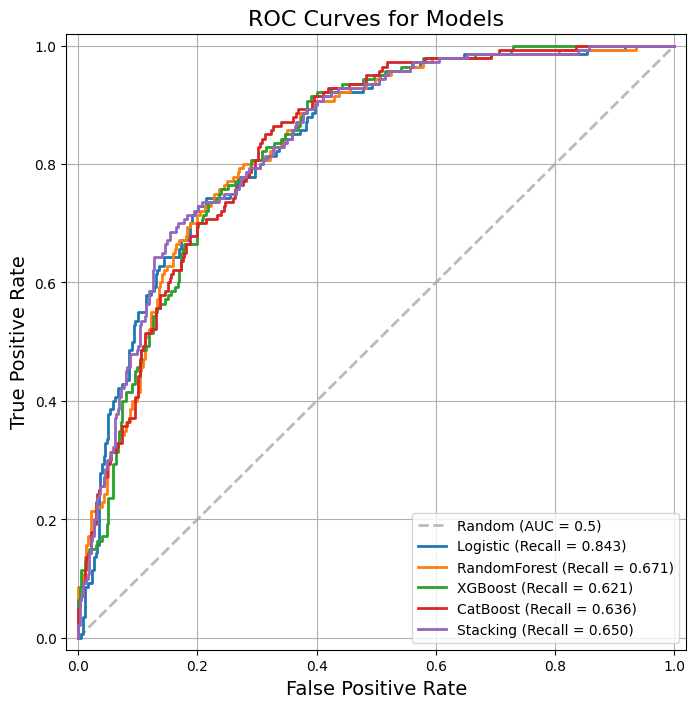

In [ ]:
import pandas as pd
import numpy as np # 임계값 조정에 필요
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# =====================================
# 0. 데이터 / 피처 세팅
# =====================================
features = [
  '하루좌식시간',
  '수면장애여부',
  '유제품섭취빈도',
  '현재흡연여부',
  '우울감경험여부',
  '활력수준',
  'BMI지수',
  '나이',
  '성별',
  '냉동식품섭취횟수',
  '운동여부'
]

df_model = df.dropna(subset=features + ['대사증후군_위험군']).copy()
X = df_model[features]
y = df_model['대사증후군_위험군']

X_train, X_test, y_train, y_test = train_test_split(
   X, y,
   test_size=0.2,
   random_state=42,
   stratify=y
)

# =====================================
# 1. 개별 모델 정의 + 학습 (기존과 동일)
# =====================================

models = {}

# 1) Logistic (스케일링 포함)
logit_clf = Pipeline([
  ('scaler', StandardScaler()),
  ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs'))
])
logit_clf.fit(X_train, y_train)
models['Logistic'] = logit_clf

# 2) RandomForest
rf_clf = RandomForestClassifier(
  n_estimators=500,
  max_depth=None,
  min_samples_split=5,
  min_samples_leaf=3,
  random_state=42,
  n_jobs=-1
)
rf_clf.fit(X_train, y_train)
models['RandomForest'] = rf_clf

# 3) XGBoost
xgb_clf = XGBClassifier(
  n_estimators=500,
  max_depth=4,
  learning_rate=0.03,
  subsample=0.9,
  colsample_bytree=0.8,
  eval_metric='logloss',
  random_state=42,
  n_jobs=-1
)
xgb_clf.fit(X_train, y_train)
models['XGBoost'] = xgb_clf

# 4) CatBoost
cat_clf = CatBoostClassifier(
  iterations=600,
  depth=6,
  learning_rate=0.03,
  loss_function='Logloss',
  eval_metric='AUC',
  verbose=False,
  random_seed=42
)
cat_clf.fit(X_train, y_train)
models['CatBoost'] = cat_clf

# 5) Stacking (Logit + XGB + CatBoost)
stack_clf = StackingClassifier(
  estimators=[
    ('logit', logit_clf),
    ('xgb', xgb_clf),
    ('cat', cat_clf)
  ],
  final_estimator=LogisticRegression(max_iter=1000, solver='lbfgs'),
  stack_method='predict_proba',
  n_jobs=-1
)
stack_clf.fit(X_train, y_train)
models['Stacking'] = stack_clf

# =====================================
# 2. 공통 성능 평가 함수 및 임계값 0.3 적용 (수정됨)
# =====================================
def model_metrics(y_true, y_pred, y_proba):
  # Precision, Recall, F1 계산 시 zero_division=0 추가 (분모 0 방지)
  return {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision(1)": precision_score(y_true, y_pred, zero_division=0),
    "Recall(1)": recall_score(y_true, y_pred, zero_division=0),
    "F1(1)": f1_score(y_true, y_pred, zero_division=0),
    "AUC": roc_auc_score(y_true, y_proba)
  }

results = {}
threshold = 0.4 # <--- 임계값을 0.4으로 설정

for name, model in models.items():
  # 모델의 예측 확률 계산
  y_proba = model.predict_proba(X_test)[:, 1]

  # 임계값 0.3을 기준으로 예측값 (y_pred) 생성
  # np.where 대신 (y_proba >= threshold).astype(int)를 사용하여 예측값 생성
  y_pred = (y_proba >= threshold).astype(int)

  # 성능 지표 계산
  results[name] = model_metrics(y_test, y_pred, y_proba)

df_results = pd.DataFrame(results).T.round(4)


# =====================================
# 3. ROC Curve 시각화 (Recall 값 라벨 적용)
# =====================================

# 그래프 영역 설정
plt.figure(figsize=(8, 8))

# 대각선 (랜덤 모델) 추가
# fpr = [0, 1], tpr = [0, 1], AUC = 0.5
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='darkgray',
         label='Random (AUC = 0.5)', alpha=.8) # 랜덤 모델은 AUC 유지


# 각 모델별 ROC Curve 및 Recall 값 라벨링
for name, model in models.items():
    # 테스트 데이터에 대한 예측 확률 (Positive 클래스, 즉 1일 확률) 계산
    y_proba = model.predict_proba(X_test)[:, 1]

    # ROC Curve 계산
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    # ----------------------------------------------------
    # Recall 값 가져오기 (임계값 0.4 적용된 Recall(1) 사용)
    # ----------------------------------------------------
    try:
        # df_results DataFrame에서 해당 모델의 Recall(1) 값을 가져옵니다.
        # 이 값은 이미 임계값 0.4를 적용하여 계산된 값입니다.
        model_recall = df_results.loc[name, 'Recall(1)']
    except KeyError:
        # df_results에 문제가 있을 경우, 안전을 위해 AUC를 임시로 사용
        roc_auc = auc(fpr, tpr)
        model_recall = roc_auc
        print(f"Warning: df_results에 '{name}' 모델의 Recall 값이 없습니다. AUC를 대신 표시합니다.")
    # ----------------------------------------------------

    # ROC Curve 플롯 (라벨에 Recall 값 적용)
    # Recall 값이 임계값 0.4에서 계산되었다는 것을 명시합니다.
    plt.plot(fpr, tpr, lw=2,
             label=f'{name} (Recall = {model_recall:.3f})')

# 그래프 설정
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for Models', fontsize=16)
plt.legend(loc='lower right', fontsize=10) # 범례 위치
plt.grid(True)
plt.show()

# =====================================

In [ ]:
df_results

,Accuracy,Precision(1),Recall(1),F1(1),AUC
Logistic,0.6983,0.4683,0.8429,0.6020,0.8356
RandomForest,0.7814,0.5839,0.6714,0.6246,0.8322
XGBoost,0.7737,0.5762,0.6214,0.5979,0.8312
CatBoost,0.7756,0.5779,0.6357,0.6054,0.8330
Stacking,0.8027,0.6319,0.6500,0.6408,0.8386


# 대시보드를 위한 로지스틱 모델 선택 후 AI 학습

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# =====================================
# 0. 데이터 / 피처 세팅
# =====================================
features = [
  '하루좌식시간',
  '수면장애여부',
  '유제품섭취빈도',
  '현재흡연여부',
  '우울감경험여부',
  '활력수준',
  'BMI지수',
  '나이',
  '성별',
  '냉동식품섭취횟수',
  '운동여부'
]


df_model = df.dropna(subset=features + ['대사증후군_위험군']).copy()
X = df_model[features]
y = df_model['대사증후군_위험군']

X_train, X_test, y_train, y_test = train_test_split(
   X, y,
   test_size=0.2,
   random_state=42,
   stratify=y
)

# =====================================
# 1. Logistic 모델 정의 및 학습
# =====================================
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs', random_state=42))
])

logistic_pipeline.fit(X_train, y_train)

# =====================================
# 2. 임계값 0.4 적용 및 성능 평가 함수
# =====================================
def evaluate_model_with_threshold(model, X_test, y_test, threshold):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    results = {
        "Threshold": threshold,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision(1)": precision_score(y_test, y_pred, zero_division=0),
        "Recall(1)": recall_score(y_test, y_pred, zero_division=0),
        "F1(1)": f1_score(y_test, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_test, y_proba)
    }
    return pd.Series(results).round(4)

# 최종 성능 출력
threshold_value = 0.4
df_final_metrics = evaluate_model_with_threshold(logistic_pipeline, X_test, y_test, threshold_value)

print(f"--- 최종 Logistic Regression 모델 성능 (Threshold = {threshold_value}) ---")
print(df_final_metrics)

--- 최종 Logistic Regression 모델 성능 (Threshold = 0.4) ---
Threshold       0.4000
Accuracy        0.6983
Precision(1)    0.4683
Recall(1)       0.8429
F1(1)           0.6020
AUC             0.8356
dtype: float64


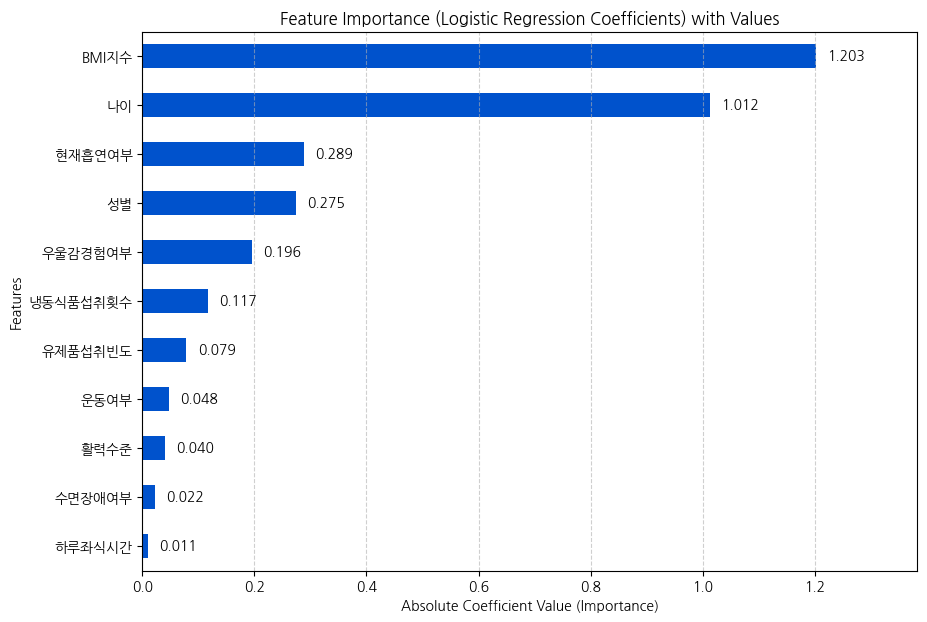

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 🚨 이 줄은 항상 코드 블록의 맨 위에 유지되어야 합니다.
%matplotlib inline

# 한글 폰트 설정 (다시 한번 포함)
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# =========================================================================
# Feature Importance 계산 (이전 코드와 동일)
# =========================================================================
# 여기서는 models['Logistic']이 파이프라인 객체라고 가정합니다.
try:
    logistic_model = models['Logistic']
except NameError:
    print("⚠️ 경고: 'models' 딕셔너리가 정의되지 않았습니다. 'logistic_pipeline'이 정의되어 있다고 가정하고 진행합니다.")
    logistic_model = logistic_pipeline

coefficients = logistic_model['clf'].coef_[0]
feature_importance = pd.Series(
    data=np.abs(coefficients),
    index=X_train.columns
).sort_values(ascending=False)

# =========================================================================
# 시각화 (값 표시 기능 추가)
# =========================================================================
plt.figure(figsize=(10, 7))

# 수평 막대 그래프(Bar plot)로 시각화
ax = feature_importance.plot(kind='barh', color='#0052cc')

# 각 막대 옆에 값 표시
for i, v in enumerate(feature_importance.values):
    ax.text(v + 0.02, i, f'{v:.3f}', va='center', ha='left', fontsize=10, color='black') # .3f는 소수점 셋째자리까지 표시

plt.title('Feature Importance (Logistic Regression Coefficients) with Values')
plt.xlabel('Absolute Coefficient Value (Importance)')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # 가장 중요한 피처가 위에 오도록 Y축 순서 반전
plt.grid(axis='x', linestyle='--', alpha=0.6)

# x축 범위 조정 (값 표시를 위해 약간 여유를 줍니다)
plt.xlim(0, feature_importance.max() * 1.15)

plt.show()

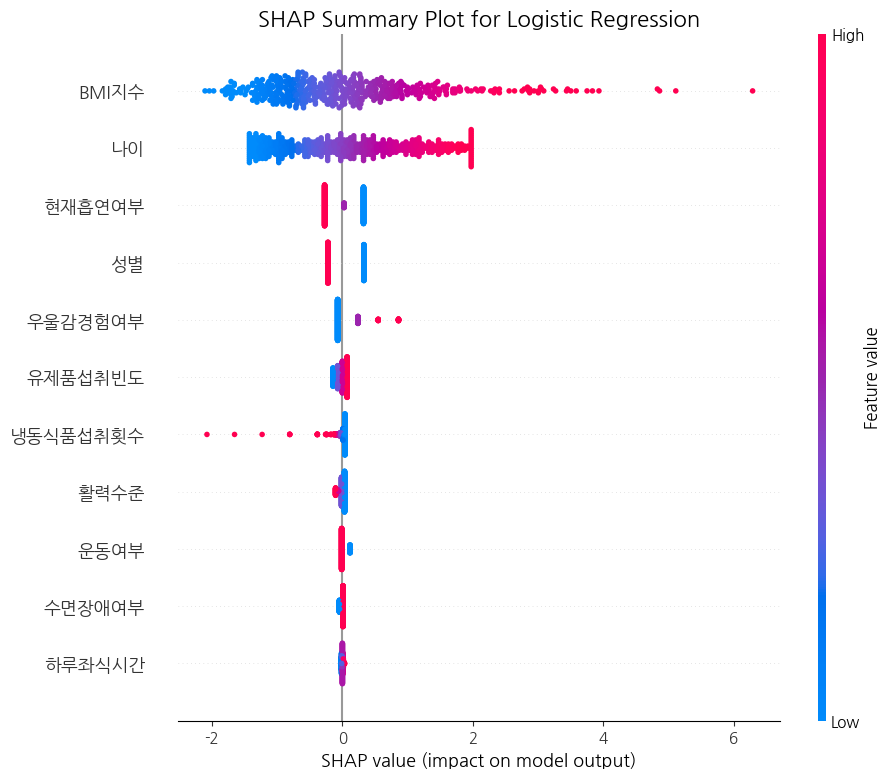

In [ ]:
# SHAP 라이브러리 설치 (설치되어 있지 않다면 실행)
# !pip install shap

import shap
import numpy as np
import matplotlib.pyplot as plt

# 1. 모델 및 데이터 준비 (이전 코드에서 정의된 변수 사용)
# Logistic Regression 파이프라인 객체 (스케일러 포함)
logistic_model = models['Logistic']
# X_test는 Pandas DataFrame 형태로 준비합니다.
X_test_df = X_test.copy()

# 2. Explainer 정의 및 SHAP 값 계산
# Logistic Regression은 Pipeline이므로, 스케일링된 데이터를 Explainer에 전달해야 합니다.
# Pipeline의 첫 번째 단계인 StandardScaler를 사용하여 X_test를 변환합니다.
X_test_scaled = logistic_model['scaler'].transform(X_test_df)

# Pipeline의 두 번째 단계인 LogisticRegression 모델을 가져옵니다.
clf_model = logistic_model['clf']

# LinearExplainer 사용 (선형 모델에 적합)
explainer = shap.LinearExplainer(clf_model, X_test_scaled)
shap_values = explainer.shap_values(X_test_scaled)

# 3. SHAP Summary Plot 시각화
# Summary plot은 피처 중요도와 피처 값의 영향을 한눈에 보여줍니다.

# 한글 폰트 설정을 다시 적용 (혹시 모를 깨짐 방지)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# SHAP plot을 그릴 때 feature 이름을 원래대로 매핑합니다.
shap.summary_plot(
    shap_values,
    X_test_scaled,
    feature_names=X_test_df.columns,
    show=False
)

# SHAP 라이브러리에서 기본적으로 사용하는 matplotlib figure를 가져와 설정
plt.gcf().set_size_inches(10, 8)
plt.title("SHAP Summary Plot for Logistic Regression", fontsize=16)
plt.show()

In [ ]:
import joblib

# 이 객체를 'model_pipeline.pkl' 파일로 저장합니다.
joblib.dump(logistic_pipeline, 'metabolic_syndrome_predictor.pkl')

print("✅ 모델 파이프라인(Scaler 포함)이 'metabolic_syndrome_predictor.pkl' 파일로 저장되었습니다.")

✅ 모델 파이프라인(Scaler 포함)이 'metabolic_syndrome_predictor.pkl' 파일로 저장되었습니다.
